# Import Your Own Data

## Import Packages

In [1]:
%reload_ext autoreload
from util.dependencies import *
from settings import USER_ID
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, StringType, FloatType, TimestampType, IntegerType
from cerebralcortex.data_importer.data_parsers import csv_data_parser
from cerebralcortex.data_importer import import_dir
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np

# Import Data

In [ ]:
# import CSV/IoT data (demo stream name - demo-location-data-stream)
import_dir(
    cc_config="/home/md2k/cc_conf/",
    input_data_dir="sample_data/",
    user_id=USER_ID,
    data_file_extension=[".csv"],
    data_parser=csv_data_parser,
    gen_report=True
)

## Create CerebralCortex object

In [2]:
CC = Kernel("/home/md2k/cc_conf/")

## View Imported Data

In [3]:
iot_stream = CC.get_stream("iot-data-stream")
iot_stream.show(5, truncate=False)

+-------------------+-------------------+-------------------+-------+------------------------------------+
|timestamp          |localtime          |some_vals          |version|user                                |
+-------------------+-------------------+-------------------+-------+------------------------------------+
|2019-01-09 17:35:00|2019-01-09 17:35:00|0.0851887269487499 |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:01|2019-01-09 17:35:01|0.16867549655743164|1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:02|2019-01-09 17:35:02|0.7404850816560419 |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:03|2019-01-09 17:35:03|0.7131609970182962 |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:04|2019-01-09 17:35:04|0.24253081438369195|1      |00000000-afb8-476e-9872-6472b4e66b68|
+-------------------+-------------------+-------------------+-------+------------------------------------+
only showing top 5 rows



In [4]:
#iot_stream.metadata

## Write a smoothing algorithm

### Define Schema

In [12]:
schema = StructType([
    StructField("smooth_vals",  FloatType())
])

### Write a user defined function (UDF)

In [6]:
@F.udf(schema)
def smooth_algo(vals):
    return [sum(vals)/len(vals)]

## Run smoothing algorithm on imported data

In [10]:
smooth_stream = iot_stream.run_algorithm(smooth_algo, columnNames=["some_vals"], windowDuration=10)
smooth_stream.show(truncate=False)

+-------------------+------------------------------------+-------+------------------------------------------+-----------+
|timestamp          |user                                |version|window                                    |smooth_vals|
+-------------------+------------------------------------+-------+------------------------------------------+-----------+
|2019-01-09 17:46:30|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:46:30, 2019-01-09 17:46:40]|0.37378517 |
|2019-01-09 17:39:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:39:00, 2019-01-09 17:39:10]|0.38799626 |
|2019-01-09 17:51:10|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:51:10, 2019-01-09 17:51:20]|0.6942901  |
|2019-01-09 17:44:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:44:00, 2019-01-09 17:44:10]|0.36333913 |
|2019-01-09 17:46:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:46:00, 2019-01-09 17:46:10]|0.49662432 |
|2019-01-09 17:38:30|000

## Visualize data

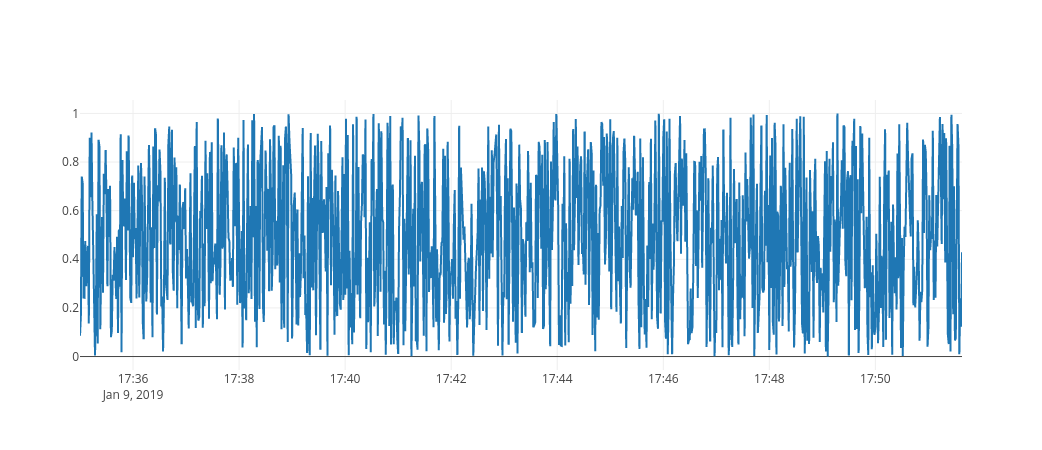

In [8]:
iot_stream.plot()

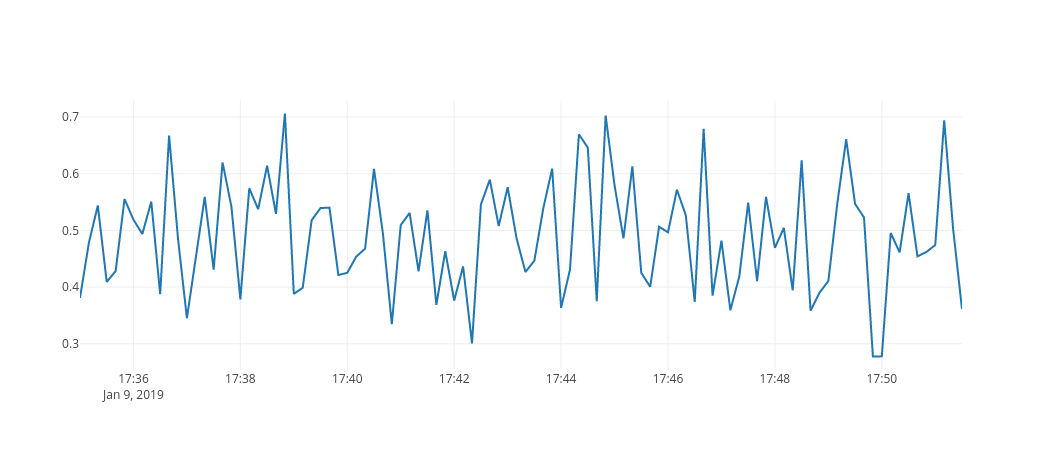

In [11]:
smooth_stream.plot()